<a href="https://colab.research.google.com/github/alorozco53/F.U.N./blob/master/image_captioning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning scripts in Pytorch

## Tutorial

Based on https://medium.com/analytics-vidhya/introduction-to-image-caption-generation-using-the-avengers-infinity-war-characters-6f14df09dbe5

### Data

In [1]:
# Download pretrained model
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0 -O pretrained_model.zip

--2019-05-01 02:02:00--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2019-05-01 02:02:00--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca395ff4c9220265fa0b70c0b45.dl.dropboxusercontent.com/cd/0/inline/AgBC4Qv4aQJx-ZcjUtr-R-wPb2V_qd8_SE1Ca9hWgEmHTwWQPVrzvl90qfIjTh93y2GFiwN_Dr6ih5-2qVo79iiKvQxzp6eId07oPJLnZLRQJiT0sbE2bAqIIv73m1-tv04/file# [following]
--2019-05-01 02:02:01--  https://uca395ff4c9220265fa0b70c0b45.dl.dropboxusercontent.com/cd/0/inline/AgBC4Qv4aQJx-ZcjUtr-R-wPb2V_qd8_SE1Ca9hWgEmHTwWQPVrzvl90qfIjTh93y2GFiwN_Dr6ih5-2qV

In [2]:
# Download vocabulary
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0 -O vocap.zip

--2019-05-01 02:02:55--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2019-05-01 02:02:56--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6eacc94c8607e064d341477fe3.dl.dropboxusercontent.com/cd/0/inline/AgDblnakOCjNNn6jz1yFVAEUpGXMkv-CpMeiGKVMBKCjMIxN3c3zOkSwzvpqV1caofwm4rwtTizwySbagD_z66NUPSVAoy2sxHMTXhCgOlfDP5UtPQg4MMlIlen33Vz_dg8/file# [following]
--2019-05-01 02:02:56--  https://uc6eacc94c8607e064d341477fe3.dl.dropboxusercontent.com/cd/0/inline/AgDblnakOCjNNn6jz1yFVAEUpGXMkv-CpMeiGKVMBKCjMIxN3c3zOkSwzvpqV1caofwm4rwtTizwySbagD_z66NUPSVAoy2sxHMTXhCgOlfDP5UtPQg

In [5]:
# Extract both files and save accordingly
!mkdir data
!mkdir models
!unzip pretrained_model.zip -d models/
!unzip vocap.zip -d data/

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘models’: File exists
Archive:  pretrained_model.zip
replace models/encoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: models/encoder-5-3000.pkl  
  inflating: models/decoder-5-3000.pkl  
Archive:  vocap.zip
  inflating: data/vocab.pkl          


### Dependencies (installation)

In [7]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 816 (delta 0), reused 1 (delta 0), pack-reused 813
Receiving objects: 100% (816/816), 12.78 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (430/430), done.


In [12]:
!cd pytorch-tutorial/tutorials/03-advanced/image_captioning/ && pip install -r requirements.txt

In [0]:
!mv pytorch-tutorial/tutorials/03-advanced/image_captioning/* .

### Library imports

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os

from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Image processing

In [0]:
def load_image(image_path, transform=None): 
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

### Config Variables

In [0]:
# MODEL DIRS
ENCODER_PATH = 'models/encoder-5-3000.pkl'
DECODER_PATH = 'models/decoder-5-3000.pkl'
VOCAB_PATH = 'data/vocab.pkl'

# CONSTANTS
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1

### Models

In [0]:
def PretrainedResNet(image_path, encoder_path=ENCODER_PATH, 
                     decoder_path=DECODER_PATH,
                     vocab_path=VOCAB_PATH,
                     embed_size=EMBED_SIZE,
                     hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
        
    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
    
    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate a caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)[8:-5].title()
    
    # Print out the image and the generated caption
    image = Image.open(image_path)
    return sentence, image

### Image prediction

A Group Of Giraffes Standing Next To Each Other . 


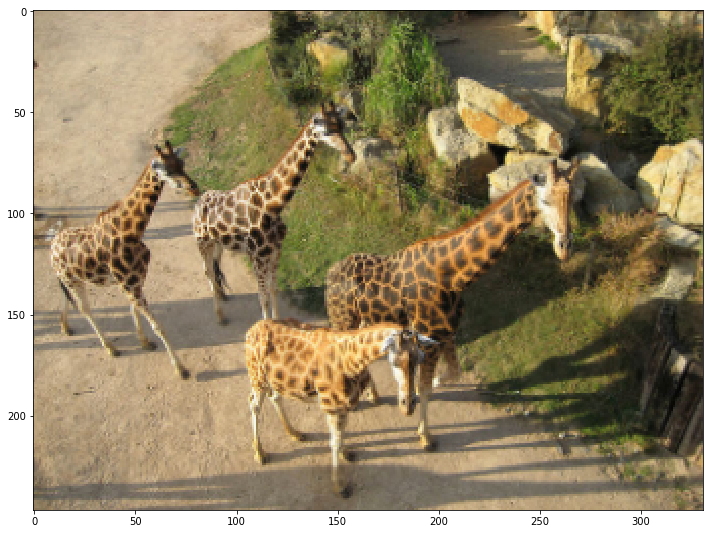

In [35]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='png/example.png')
plt.imshow(image)
print(predicted_label)

A Man Wearing A Suit And Tie With A Tie . 


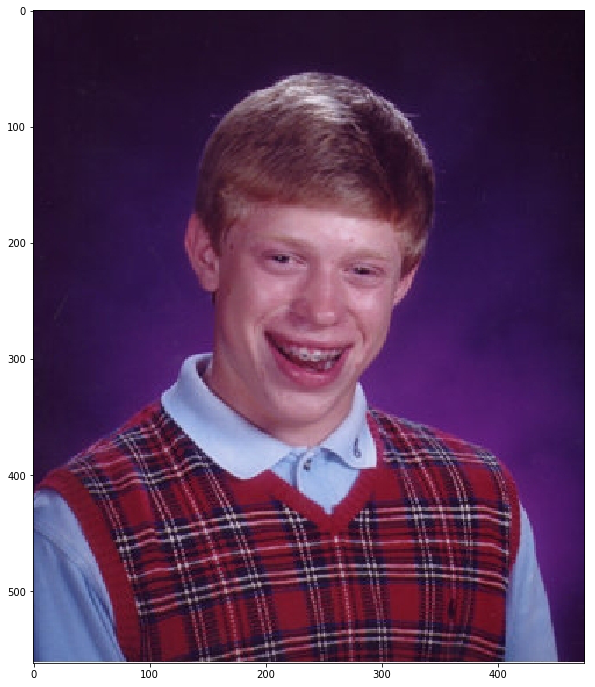

In [36]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='Bad-Luck-Brian-Meme.jpg')
plt.imshow(image)
print(predicted_label)

A Small Dog Is Holding A Frisbee In A Room . 


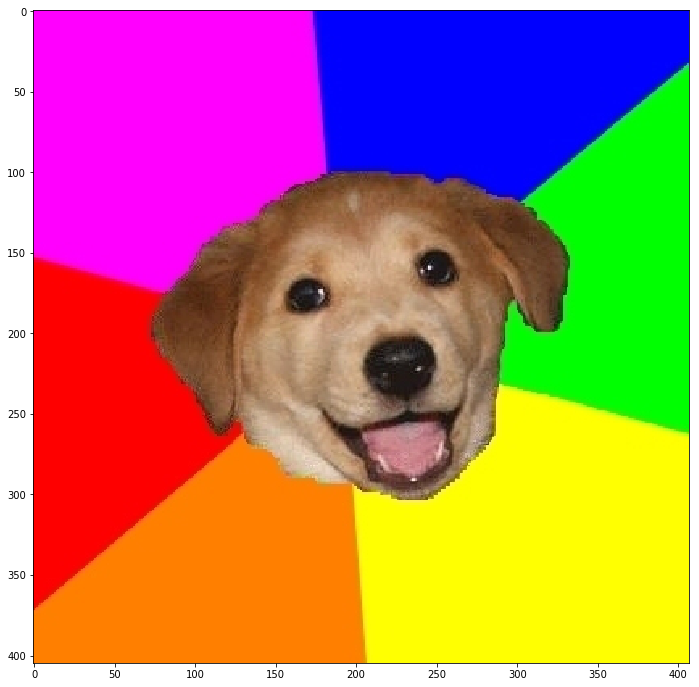

In [37]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='Advice-Dog.jpg')
plt.imshow(image)
print(predicted_label)

A White And White Cat Sitting On A Blue Blanket . 


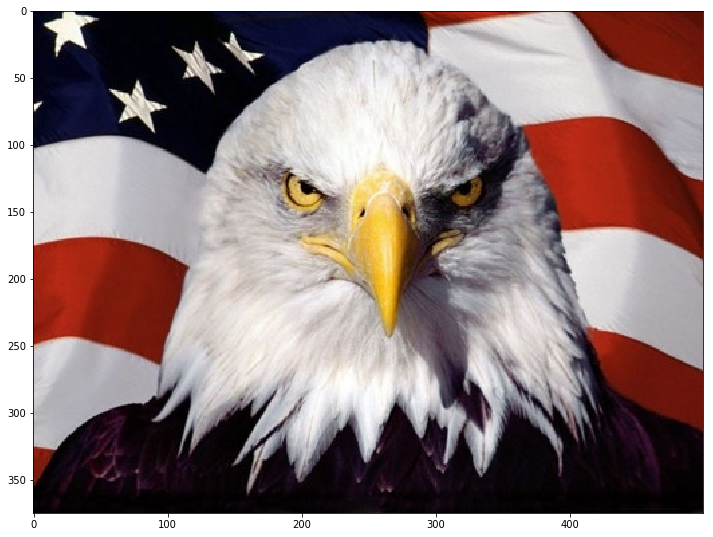

In [38]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='American-Pride-Eagle.jpg')
plt.imshow(image)
print(predicted_label)

A Woman Is Holding A Cell Phone In Her Hand . 


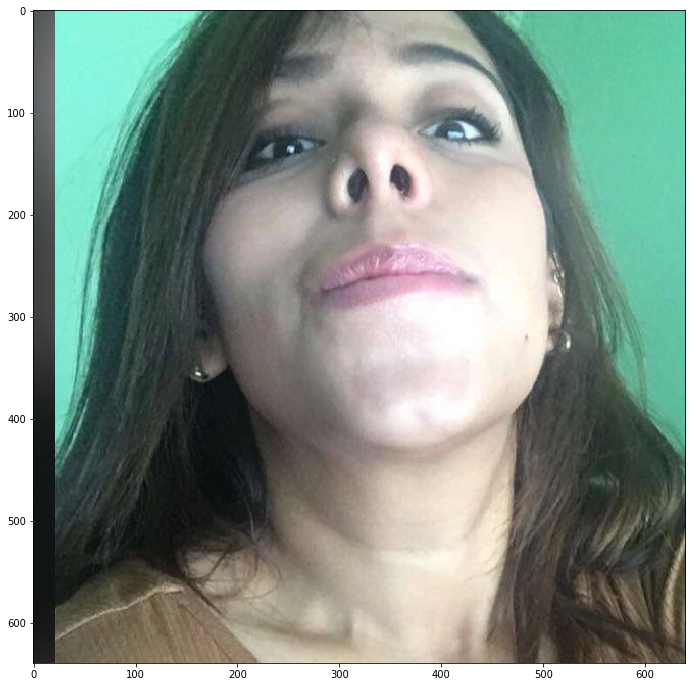

In [39]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='memelisa.jpeg')
plt.imshow(image)
print(predicted_label)

### Image prediction using web camera

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


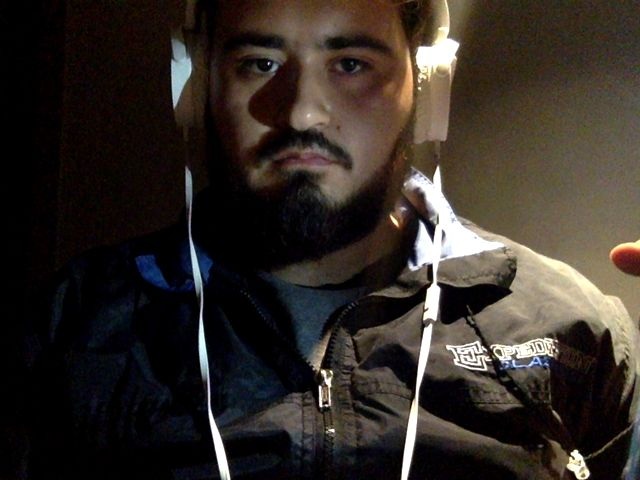

In [47]:
from IPython.display import Image as IpyImage
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(IpyImage(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

A Man Holding A Smart Phone In His Hand . 


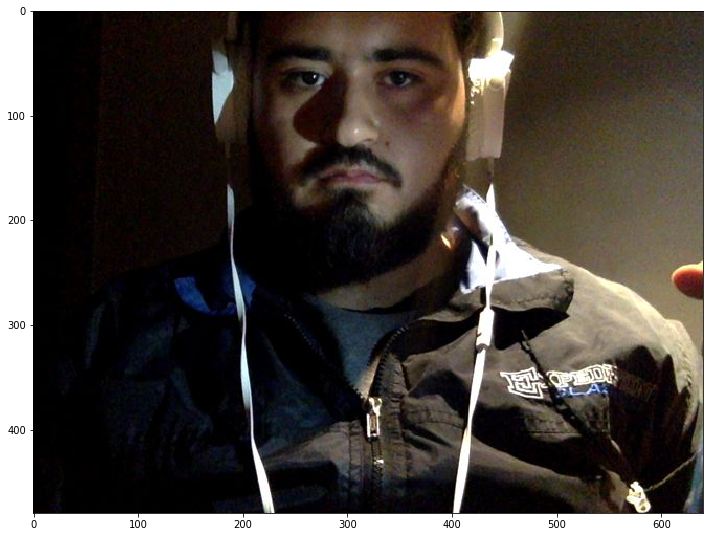

In [48]:
plt.figure(figsize=(12,12))
predicted_label, image = PretrainedResNet(image_path='photo.jpg')
plt.imshow(image)
print(predicted_label)